<a href="https://colab.research.google.com/github/harisonmg/tensorflow-exam-prep/blob/main/notebooks/cats_vs_dogs_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Getting the data

In [1]:
#@title Imports
from zipfile import ZipFile

In [2]:
#@title Config
# If the raw data URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# and right click on the 'Download Manually' link to get a new URL
RAW_DATA = {
    "url":  "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip",
    "local": "cats_and_dogs.zip"
}
FILTERED_DATA = {
    "url": "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
    "local": "cats_and_dogs_filtered.zip"
}

In [3]:
#@title Downloading and extracting the data
dataset = FILTERED_DATA #@param ["RAW_DATA", "FILTERED_DATA"] {type:"raw"}
dataset_url = dataset["url"]
dataset_download = dataset["local"]

!wget --no-check-certificate {dataset_url} -O {dataset_download}

with ZipFile(dataset_download, "r") as zip_ref:
    zip_ref.extractall()

--2021-08-17 09:46:49--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   104MB/s    in 0.6s    

2021-08-17 09:46:49 (104 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



## Splitting the data

In [4]:
#@title Imports
from pathlib import Path
import shutil

from sklearn.model_selection import train_test_split
import numpy as np

In [5]:
#@title Config
BASE_DIR = Path(".")
data_dir = BASE_DIR / "PetImages"
data_subsets_dir = BASE_DIR / Path(dataset_download).stem

In [6]:
#@title List the number of images per category
# Should be 12501 for each
correct_num_files = 12501
for file_path in list(data_dir.glob("*")):
    num_files = len(list(file_path.glob("*")))
    print(f"{file_path.name} images: {num_files}")
    assert num_files == correct_num_files

In [7]:
#@title Helper functions
def copy_files(src_paths, dst_path):
    if dst_path.exists():
        shutil.rmtree(dst_path)

    dst_path.mkdir(parents=True)
    for path in src_paths:
        if path.stat().st_size > 0:
            shutil.copy(path, dst_path)
        else:
            print(f"{path.name} is zero length, so ignoring")

def train_val_test_split(
    data_dir, subsets_dir, train_size=0.7, test_split=False, random_state=42
):
    category_paths = list(data_dir.glob("*"))
    subsets = ["training", "validation", "test"]
    category_subsets = {}

    if not test_split:
        subsets.remove("test")
    
    # get the subsets 
    for category_path in category_paths:
        category = category_path.name
        img = np.array(sorted(list(category_path.glob("*"))))

        # split
        train_img, val_img = train_test_split(
            img, train_size=train_size, random_state=random_state
        )
        if test_split:
            val_img, test_img = train_test_split(
                val_img, train_size=train_size, random_state=random_state
            )
            img_subsets = [train_img, val_img, test_img]
        else:
            img_subsets = [train_img, val_img]
        
        # test
        subset_lengths = [len(subset) for subset in img_subsets]
        assert sum(subset_lengths) == img.size

        # save
        category_subsets[category] = dict(zip(subsets, img_subsets))

    # copy the subsets
    for category, data in category_subsets.items():
        category = category.lower().replace(" ", "_")
        formatting = "\n" + "="*10 + " "*4
        print(f"{formatting} Copying {category} subsets {formatting[::-1]}")

        for name, file_paths in data.items():
            dst_path = subsets_dir / name / category
            copy_files(file_paths, dst_path)
            files_copied = len(list(dst_path.glob("*")))
            print(f"{name.title()}: {files_copied}")    
    return category_subsets

In [8]:
#@title Create train, validation and test splits
category_subsets = train_val_test_split(data_dir, data_subsets_dir, train_size=0.9, test_split=False)
subset_dirs = [path for path in list(data_subsets_dir.glob("*")) if path.is_dir()]
print(f"\nSubset directories: {subset_dirs}")

train_dir = data_subsets_dir / "train"
validation_dir = data_subsets_dir / "validation"


Subset directories: [PosixPath('cats_and_dogs_filtered/train'), PosixPath('cats_and_dogs_filtered/validation')]


## Visualizing the data

In [9]:
#@title Imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [10]:
#@title Helper function
def plot_images(data_dir, category_rows=2, cols=4, img_size=4):
    category_paths = [path for path in list(data_dir.glob("*")) if path.is_dir()]
    images = {category.name: list(category.glob("*")) for category in category_paths}

    rows = category_rows * len(category_paths)
    sample_images = {}
    for category, img_paths in images.items():
        sample_images[category] = np.random.choice(
            img_paths, category_rows*cols, replace=False
        )

    fig, axes = plt.subplots(rows, cols, figsize=(img_size*rows, img_size*cols))
    for i, img_data in enumerate(sample_images.items()):
        category, img_paths = img_data
        for j, path in enumerate(img_paths):
            idx = j + i*(category_rows*cols)
            ax = axes[idx//cols, idx%cols]
            img = mpimg.imread(path)
            ax.imshow(img)
            ax.set_title(f"{path.name}: {category}")
            ax.axis("off")
    plt.show()

In [11]:
#@title Plotting sample  training images 
# plot_images(train_dir)

In [12]:
#@title Plotting sample validation images 
# plot_images(validation_dir)

## Model training

In [13]:
#@title Imports
from datetime import datetime

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks, layers, models, optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf

print(f"Tensorflow: {tf.__version__}")

Tensorflow: 2.5.0


In [14]:
#@title Config
BATCH_SIZE = 32
IMAGE_SIZE = (150, 150)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
MODEL_LOGS_DIR = data_subsets_dir / f"{data_subsets_dir}_model"

epochs = 200
learning_rate = 1e-4
early_stopping_rounds = 5

current_logs_dir = MODEL_LOGS_DIR / datetime.now().isoformat()
checkpoint_filepath = current_logs_dir / "checkpoints"
tensorboard_logs_dir = current_logs_dir / "logs"

model_log_paths = [checkpoint_filepath, tensorboard_logs_dir]
for path in model_log_paths:
    if not path.exists():
        path.mkdir(parents=True)
        print(f"Created: {path}")

Created: cats_and_dogs_filtered/cats_and_dogs_filtered_model/2021-08-17T09:46:53.052445/checkpoints
Created: cats_and_dogs_filtered/cats_and_dogs_filtered_model/2021-08-17T09:46:53.052445/logs


In [15]:
#@title Downloading pre-trained model weights
model_weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_weights_download = "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

!wget --no-check-certificate {model_weights_url} -O {model_weights_download}

--2021-08-17 09:46:53--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

inception_v3_weight 100%[===================>]  83.84M   224MB/s    in 0.4s    

2021-08-17 09:46:53 (224 MB/s) - ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [16]:
#@title Loading the pre-trained model
pre_trained_model = InceptionV3(
    input_shape=IMAGE_SHAPE, include_top=False, weights=None
)
pre_trained_model.load_weights(model_weights_download)

for layer in pre_trained_model.layers:
    layer.trainable = False

# [layer.name for layer in pre_trained_model.layers if layer.name.__contains__("mixed")]
last_layer_name = "mixed8" #@param ["mixed0", "mixed1", "mixed2", "mixed3", "mixed4", "mixed5", 'mixed6', "mixed7", "mixed8", "mixed9_0", "mixed9", "mixed9_1", "mixed10"]
last_layer = pre_trained_model.get_layer(last_layer_name)
last_output = last_layer.output

show_model_summary = False #@param {type:"boolean"}
if show_model_summary:
    pre_trained_model.summary()
else:
    print(f"Model: {pre_trained_model.name}")
    print(f"Number of layers: {len(pre_trained_model.layers)}")
    print(f"Last layer output shape: {last_layer.output_shape}")

Model: inception_v3
Number of layers: 311
Last layer output shape: (None, 3, 3, 1280)


In [17]:
#@title Model definition
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           

model = models.Model(pre_trained_model.input, x) 
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [18]:
#@title Loading the data for training
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [19]:
#@title Model callbacks
class CustomCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    threshold = 0.98
    if(logs.get("val_accuracy") > threshold):
      print(f"\nReached {threshold:.1%} accuracy so cancelling training!")
      self.model.stop_training = True

model_callbacks = [
             CustomCallback(),
             callbacks.ModelCheckpoint(filepath=checkpoint_filepath),
             callbacks.EarlyStopping(patience=early_stopping_rounds),
             callbacks.TensorBoard(tensorboard_logs_dir)
]

In [20]:
#@title Training the model
history = model.fit(
    train_generator,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator,
    callbacks=model_callbacks
)

Epoch 1/200
63/63 [==============================] - 53s 325ms/step - loss: 0.4315 - accuracy: 0.8455 - val_loss: 0.0962 - val_accuracy: 0.9620
INFO:tensorflow:Assets written to: cats_and_dogs_filtered/cats_and_dogs_filtered_model/2021-08-17T09:46:53.052445/checkpoints/assets
Epoch 2/200
63/63 [==============================] - 19s 306ms/step - loss: 0.2312 - accuracy: 0.9065 - val_loss: 0.1108 - val_accuracy: 0.9610
INFO:tensorflow:Assets written to: cats_and_dogs_filtered/cats_and_dogs_filtered_model/2021-08-17T09:46:53.052445/checkpoints/assets
Epoch 3/200
63/63 [==============================] - 20s 315ms/step - loss: 0.2151 - accuracy: 0.9100 - val_loss: 0.0906 - val_accuracy: 0.9580
INFO:tensorflow:Assets written to: cats_and_dogs_filtered/cats_and_dogs_filtered_model/2021-08-17T09:46:53.052445/checkpoints/assets
Epoch 4/200
63/63 [==============================] - 19s 297ms/step - loss: 0.1545 - accuracy: 0.9405 - val_loss: 0.1027 - val_accuracy: 0.9550
INFO:tensorflow:Assets wr

## Model evaluation

In [21]:
#@title Imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")

In [22]:
#@title Helper function
def get_metrics(training_history, metric, validation=True):
    metrics = {
        metric: training_history.get(metric)
    }
    if validation:
        val_metric = "val_" + metric
        metrics[val_metric] = training_history.get(val_metric)
    return pd.DataFrame(metrics)

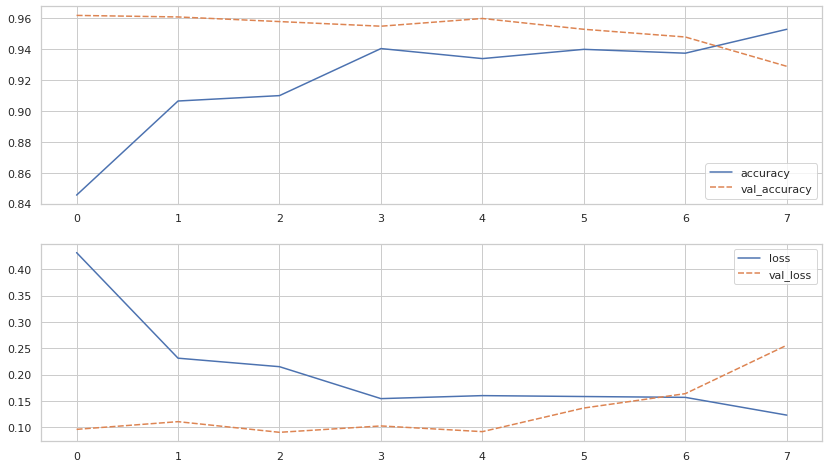

In [23]:
#@title Plot training metrics
rows, cols = 2, 1
fig, axes = plt.subplots(rows, cols, figsize=(7*rows, 8*cols))

accuracy = get_metrics(history.history, "accuracy")
loss = get_metrics(history.history, "loss")
sns.lineplot(data=accuracy, ax=axes[0])
sns.lineplot(data=loss, ax=axes[1])
plt.show()

In [24]:
# %load_ext tensorboard
# %tensorboard --logdir={tensorboard_logs_dir}

In [25]:
#@title Testing the model 
# # Here's a codeblock just for fun. You should be able to upload an image here 
# # and have it classified without crashing

# import numpy as np
# from google.colab import files
# from keras.preprocessing import image

# uploaded = files.upload()

# for fn in uploaded.keys():
 
#   # predicting images
#   path = '/content/' + fn
#   img = image.load_img(path, target_size=(# YOUR CODE HERE))
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)

#   images = np.vstack([x])
#   classes = model.predict(images, batch_size=10)
#   print(classes[0])
#   if classes[0]>0.5:
#     print(fn + " is a dog")
#   else:
#     print(fn + " is a cat")

## Saving the model to Google Drive

In [26]:
#@title Copy the model checkpoints and logs to Google Drive
from google.colab import drive

drive.mount('/content/drive')
google_drive_folder = "/content/drive/MyDrive/tensorflow"

!mkdir {google_drive_folder}
!cp -r {MODEL_LOGS_DIR} {google_drive_folder}

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/MyDrive/tensorflow’: File exists
